## Import Packages

In [1]:
import sys
sys.path.append('../../')

In [34]:
%load_ext autoreload
# import gdown
# import time
import h5py
# import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
# from matplotlib.patches import ConnectionPatch


from src.m3_learning.be.util import print_be_tree, SHO_Fitter, SHO_fit_to_array
# from src.m3_learning.nn.random import random_seed
# from src.m3_learning.viz.style import style
from src.m3_learning.be.processing import convert_amp_phase
# from src.m3_learning.viz.layout import layout_fig
from src.m3_learning.util.h5_util import make_dataset, make_group
from  src.m3_learning.util.preprocessing import global_scaler
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
# from scipy import fftpack



# style("default")
# random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Sets path to file
path = r"C:/Users/jca92/Documents/codes/m3_learning/m3_learning/papers/2023_Rapid_Fitting/data/"

In [4]:
print_be_tree(path + "data_file.h5")

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS

### Extract Data

In [5]:
# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of samples per SHO fit
num_bins = h5_f["Measurement_000"].attrs["num_bins"]

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# number of pixels in x and y dimensions
num_pix_1d = int(np.sqrt(num_pix))

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# # sampling rate
# sampling_rate = h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]

# # BE bandwidth
# be_bandwidth = h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

# # BE center frequency
# be_center_frequency = h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# extracting spectroscopic values
spectroscopic_values = h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"]

# # extract the real and imaginary components
real = h5_f["Measurement_000"]["Channel_000"]['complex']['real'][:]
imag = h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][:]

### Resampling

add something that checks if exists

In [6]:
real_resample = resample(real.reshape(num_pix, -1, num_bins), 80, axis=2)
imag_resample = resample(imag.reshape(num_pix, -1, num_bins), 80, axis=2)


raw_data_resample = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

amp_resample, phase_resample = convert_amp_phase(raw_data_resample)

make_group(h5_f["Measurement_000"]["Channel_000"], 'magn_spec_resample')

could not add group - it might already exist


In [7]:
make_dataset(h5_f["Measurement_000"]["Channel_000"], 'raw_data_resample', raw_data_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'real_resample', real_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'imag_resample', imag_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]['magn_spec_resample'], 'amp_resample', amp_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]['magn_spec_resample'], 'phase_resample', phase_resample)


## Visualizing Input Data


### Comparison of original and resampled data


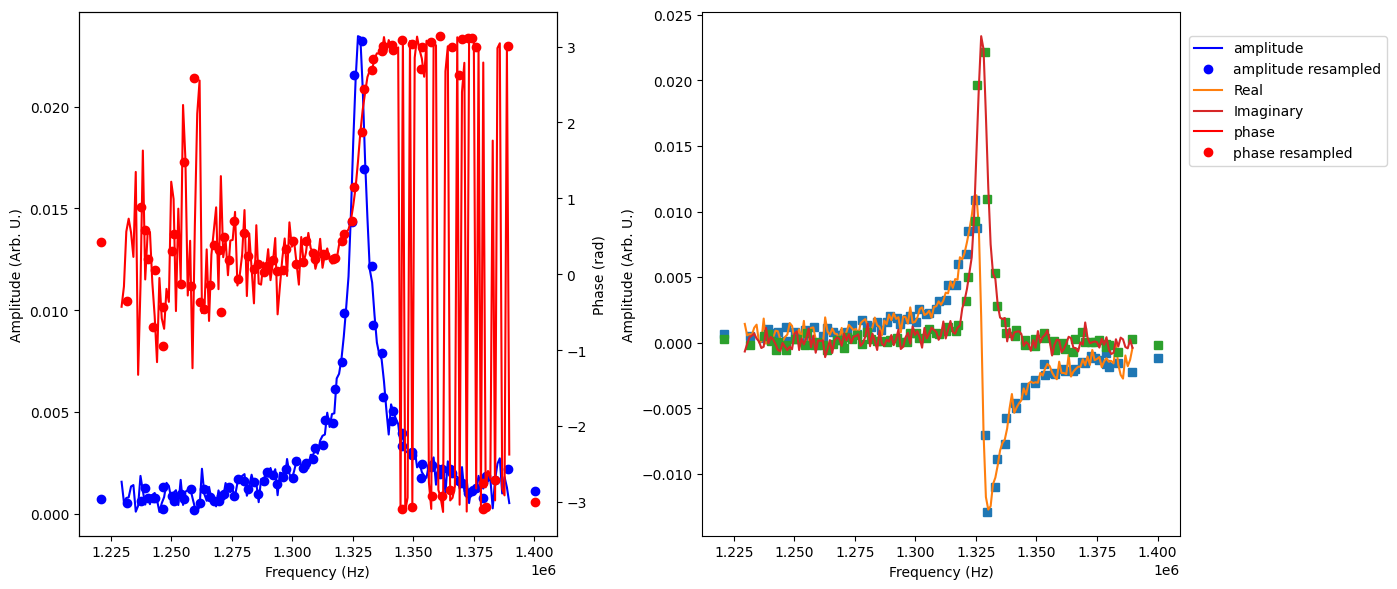

In [21]:
# generates random pixel position and timestep
pixel = np.random.randint(0, h5_f["Measurement_000"]["Channel_000"]['complex']['real'].shape[0])
timestep = np.random.randint(0, h5_f["Measurement_000"]["Channel_000"]['complex']['real'].shape[1]) // num_bins

# plot real and imaginary components of resampled data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# axs[0].set_title('Magnitude/Phase representation')
axs[0].plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][pixel].reshape(-1, num_bins)[timestep],
    label="amplitude",
    color="b",
)
axs[0].plot(
    wvec_freq,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec_resample']['amp_resample'][:].reshape(num_pix, voltage_steps, -1)[pixel, timestep],
    "o",
    label="amplitude resampled",
    color="b",
)
axs[0].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = axs[0].twinx()
ax2.plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['phase'][pixel].reshape(-1, num_bins)[timestep],
    label="phase",
    color="r",
)
ax2.plot(
    wvec_freq,
     h5_f["Measurement_000"]["Channel_000"]['magn_spec_resample']['phase_resample'][:].reshape(num_pix, voltage_steps, -1)[pixel, timestep],
    "o",
    label="phase resampled",
    color="r",
)
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

# axs[1].set_title('Real and Imaginary')
axs[1].plot(wvec_freq, real_resample[pixel, timestep], "s")

axs[1].plot(frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['real'][pixel].reshape(-1, num_bins)[timestep], label="Real")

axs[1].plot(wvec_freq, h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][pixel, timestep], "s")

axs[1].plot(
    frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][pixel].reshape(-1, num_bins)[timestep], label="Imaginary"
)

axs[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")

fig.legend(bbox_to_anchor=(1.16, 0.93), loc="upper right", borderaxespad=0.0)
fig.tight_layout()

plt.savefig(f"{path}Assets/Figures/SHO_input.png", pad_inches=1)
plt.savefig(f"{path}Assets/Figures/SHO_input.svg", pad_inches=1)

## Data Scaling

In [29]:
# scale the fit results with Standard Scaler
fit_results_scaler = StandardScaler()
SHO_fit_results = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])
scaled_fit_results = fit_results_scaler.fit_transform(SHO_fit_results.reshape(-1, 5)[:, 0:4])

make_dataset(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"], 'scaled_fit', scaled_fit_results)

Text(0.5, 1.0, 'After scaling')

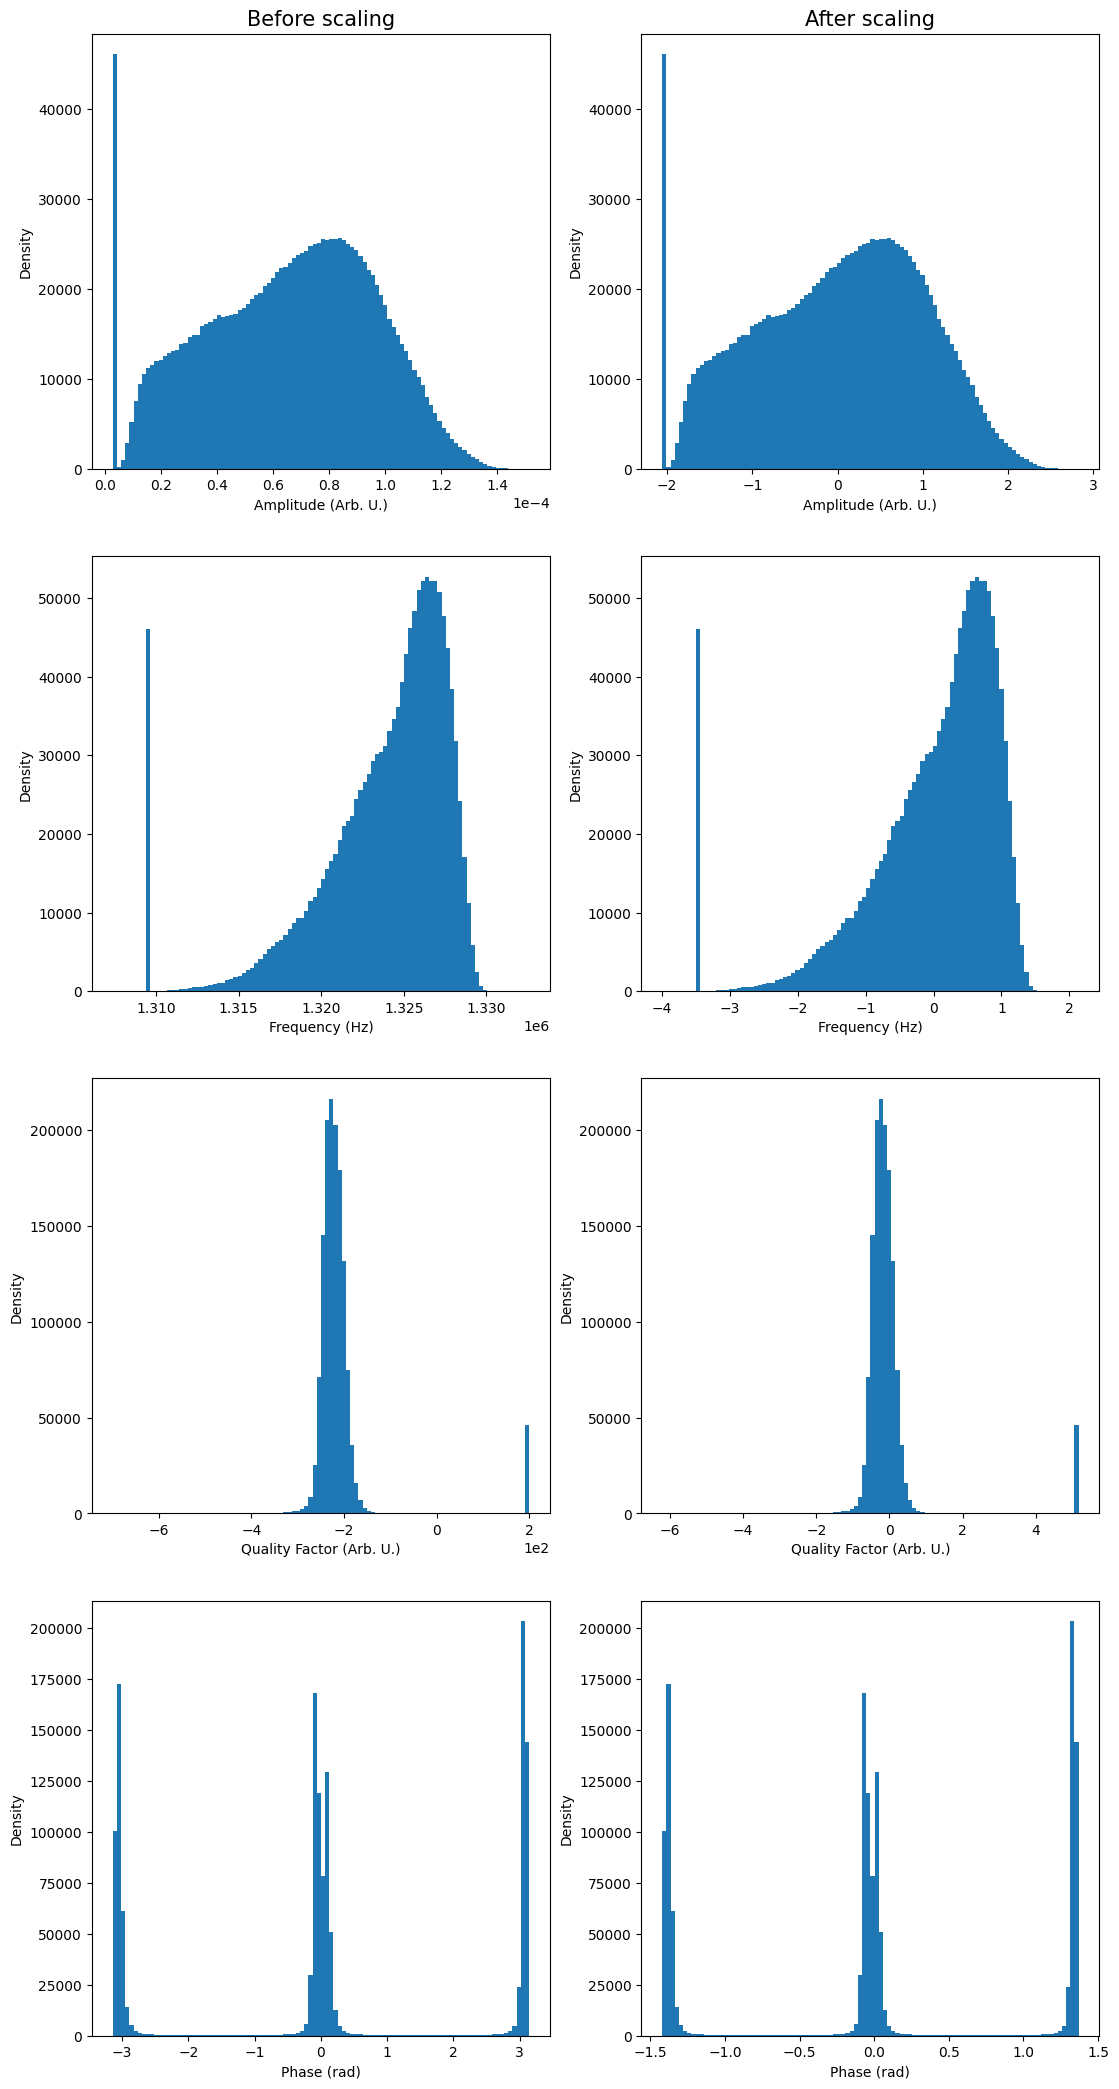

In [30]:
# check distrubutions of each parameter before and after scaling
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13, 26))

units = [
    "Amplitude (Arb. U.)",
    "Frequency (Hz)",
    "Quality Factor (Arb. U.)",
    "Phase (rad)",
]

for i in range(4):
    axs[i, 0].hist(SHO_fit_results[:, :, i].flatten(), 100)
    axs[i, 1].hist(scaled_fit_results[:, i].flatten(), 100)

i = 0
for ax in axs.flat:
    ax.set(xlabel=units[i // 2], ylabel="Density")
    i += 1
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

axs[0, 0].set_title("Before scaling", fontsize=15)
axs[0, 1].set_title("After scaling", fontsize=15)

In [35]:
# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

# saves the data to the h5_file
make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'scaled_data', np.stack((scaled_data_real, scaled_data_imag), axis=2))

In [39]:
h5_f.close()